In [180]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

In [181]:
df= pd.read_csv("data/최종_최종__월별기상관측.csv",encoding="cp949")
df= df.drop(labels="Unnamed: 0", axis=1)
df

,행정구역,지점명,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,강원도,속초,2000-01,-0.4,9.9,-10.9,90.2,152.990
1,강원도,속초,2000-02,-0.1,9.2,-8.6,8.4,329.070
2,강원도,속초,2000-03,6.9,18.5,-4.2,8.7,448.650
3,강원도,속초,2000-04,11.2,24.1,2.4,23.4,486.355
4,강원도,속초,2000-05,14.3,30.5,6.2,71.0,520.280
...,...,...,...,...,...,...,...,...
23305,경상남도,남해,2021-08,26.1,35.5,20.7,473.2,481.070
23306,경상남도,남해,2021-09,22.2,30.1,16.3,164.6,366.930
23307,경상남도,남해,2021-10,17.2,28.9,4.7,43.6,429.240
23308,경상남도,남해,2021-11,10.7,21.7,1.4,53.5,323.960


In [182]:
df['행정구역'].unique()

array(['강원도', '경기도', '인천광역시', '서울특별시', '경상북도', '충청북도', '충청남도', '대전광역시',
       '전라남도', '대구광역시', '전라북도', '울산광역시', '경상남도', '광주광역시', '부산광역시', '제주도',
       '세종특별자치시'], dtype=object)

In [183]:
city_list= ['강원도', '경기도', '인천광역시', '서울특별시', '경상북도', '충청북도', '충청남도', '대전광역시','전라남도', '대구광역시', '전라북도', '울산광역시', '경상남도', '광주광역시', '부산광역시', '제주도','세종특별자치시']
city_eng= ['gangwon', 'gyeonggi', 'incheon', 'seoul', 'gyeongbuk', 'chungbuk', 'chungnam', 'daejeon', 'jeonnam', 'daegu', 'jeonbuk', 'ulsan', 'gyeongnam', 'gwangju', 'busan', 'jeju', 'sejong']

In [184]:
grouped= df.groupby(['행정구역', '일시']).mean()
grouped

평균기온(°C)   최고기온(°C)   최저기온(°C)  월합강수량(00~24h만)(mm)  \
행정구역 일시                                                             
강원도  2000-01  -2.681818   8.690909 -14.745455           58.272727   
     2000-02  -2.872727   7.827273 -14.318182            6.509091   
     2000-03   4.790909  19.000000  -7.936364           13.790909   
     2000-04  10.154545  23.518182  -1.872727           37.354545   
     2000-05  15.618182  31.500000   4.181818           75.181818   
...                 ...        ...        ...                 ...   
충청북도 2021-08  24.160000  34.240000  17.360000          241.860000   
     2021-09  20.680000  29.100000  12.920000          191.580000   
     2021-10  13.760000  29.460000  -1.000000           35.260000   
     2021-11   6.800000  19.880000  -4.900000           47.800000   
     2021-12   0.100000  12.260000 -14.820000            5.080000   

              합계 일사량(MJ/m2)  
행정구역 일시                      
강원도  2000-01     158.358182  
     2000-02     322.926364  
     2000-03     433.992727  
     2000-04     481.298636  
     2000-05     518.235455  
...                     ...  
충청북도 2021-08     445.145000  
     2021-09     426.565000  
     2021-10     407.200000  
     2021-11     243.284000  
     2021-12     253.344000  

[4488 rows x 5 columns]

In [185]:
test= grouped.reset_index()
test['생산량']=0
test['면적']=0


In [187]:
#봄:3,4,5/ 여름:6,7,8/ 가을:9,10,11/ 겨울:12, 1, 2
#날씨 + 면적 -> 생산량
season = ["spring", "summer", "fall", "winter"]
yr_list= np.arange(2000, 2022)
detail = [".1", ".2", ".3", ".4", ".5", ".6", ".7", ".8", ".9", ".10", ".11"]
month= ["-01", "-02", "-03", "-04", "-05", "-06", "-07", "-08", "-09", "-10", "-11", "-12"]

for i in range(len(city_eng)):
    for l in range(len(season)):
        csv_name= "data/"+city_eng[i]+"_"+season[l]+".csv"
        output_df= pd.read_csv(csv_name)
        if season[l] == "spring":
            for yr in yr_list:
                try:
                    val=str(yr)
                    val1= str(yr)+detail[1]
                    for k in range(2,5):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= output_df.loc[1, val]
                        test.loc[ind, '생산량']= output_df.loc[1, val1]
                except:
                    for k in range(2,5):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= 0
                        test.loc[ind, '생산량']= 0
                
        if season[l] == 'summer':
            for yr in yr_list:
                try:
                    val= str(yr) + detail[2]
                    val1= str(yr) + detail[4]
                    for k in range(5,8):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= output_df.loc[1, val]
                        test.loc[ind, '생산량']= output_df.loc[1, val1]
                except:
                    for k in range(5,8):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= 0
                        test.loc[ind, '생산량']= 0

        if season[l] == 'fall':
            for yr in yr_list:
                try:
                    val= str(yr) + detail[5]
                    val1= str(yr) + detail[7]
                    for k in range(8, 11):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= output_df.loc[1, val]
                        test.loc[ind, '생산량']= output_df.loc[1, val1]
                except:
                    for k in range(8, 11):
                        dt= str(yr) + month[k]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= 0
                        test.loc[ind, '생산량']= 0

        if season[l] == 'winter':
            for yr in yr_list:
                try:
                    val= str(yr) + detail[8]
                    val1= str(yr) + detail[11]
                    num_list=[0,1,11]
                    for i in range(len(num_list)):
                        dt= str(yr) + month[num_list[i]]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= output_df.loc[1, val]
                        test.loc[ind, '생산량']= output_df.loc[1, val1]
                except:
                    num_list=[0,1,11]
                    for i in range(len(num_list)):
                        dt= str(yr) + month[num_list[i]]
                        ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
                        test.loc[ind, '면적']= 0
                        test.loc[ind, '생산량']= 0

C:\Users\LG-PC\AppData\Local\Temp\ipykernel_8420\2157257907.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
C:\Users\LG-PC\AppData\Local\Temp\ipykernel_8420\2157257907.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
C:\Users\LG-PC\AppData\Local\Temp\ipykernel_8420\2157257907.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
C:\Users\LG-PC\AppData\Local\Temp\ipykernel_8420\2157257907.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ind= test[test['일시'].str.contains(dt)][test['행정구역']==city_list[i]].index
C:\Users\LG-PC\AppData\Local\Temp\ipykernel_8420\2157257907.py:18: UserWarning: Boolean Series key will be reindexed to match Da

In [188]:
test1= test.set_index('행정구역')
test1

,일시,평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2),생산량,면적
행정구역,,,,,,,,
강원도,2000-01,-2.681818,8.690909,-14.745455,58.272727,158.358182,0,0
강원도,2000-02,-2.872727,7.827273,-14.318182,6.509091,322.926364,0,0
강원도,2000-03,4.790909,19.000000,-7.936364,13.790909,433.992727,87619,2147
강원도,2000-04,10.154545,23.518182,-1.872727,37.354545,481.298636,87619,2147
강원도,2000-05,15.618182,31.500000,4.181818,75.181818,518.235455,87619,2147
...,...,...,...,...,...,...,...,...
충청북도,2021-08,24.160000,34.240000,17.360000,241.860000,445.145000,0,0
충청북도,2021-09,20.680000,29.100000,12.920000,191.580000,426.565000,168678,2304
충청북도,2021-10,13.760000,29.460000,-1.000000,35.260000,407.200000,168678,2304


In [189]:
train= test1[test1['일시'].str.contains('2021') == False]
train= train[train['면적'] != 0]
train= train[train['면적'] != '0']
train= train[train['면적'] != '-']
test_new= test1[test1['일시'].str.contains('2021')]
test_new= test_new[test_new['면적'] != 0]
test_new= test_new[test_new['면적'] != '0']
test_new= test_new[test_new['면적'] != '-']

In [190]:
train= train.drop(labels="일시", axis=1)
test_new= test_new.drop(labels="일시", axis=1)

In [191]:
train['생산량']= pd.to_numeric(train['생산량'])
train['면적']= pd.to_numeric(train['면적'])
test_new['생산량']= pd.to_numeric(test_new['생산량'])
test_new['면적']= pd.to_numeric(test_new['면적'])

In [192]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

feature= train[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= train[['생산량']]

scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

X_train, X_val, y_train, y_val= train_test_split(feature_sc, target_sc, test_size=0.2)

In [193]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1807, 6) (1807, 1)
(452, 6) (452, 1)


In [194]:
X_train= X_train.reshape(1807, -1, 6)
X_val= X_val.reshape(452, -1, 6)

In [195]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', input_shape=(1, 6)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [196]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
model.fit(X_train, y_train, epochs=70, batch_size=30, callbacks=[early_stop])

Epoch 1/70
61/61 [==============================] - 2s 2ms/step - loss: 0.0318
Epoch 2/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 3/70
61/61 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 4/70
61/61 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 5/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 6/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 7/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0076
Epoch 8/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 9/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 10/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 11/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 12/70
61/61 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 13/70
61/61 [==============================

In [197]:
pred_y = model.predict(X_val)

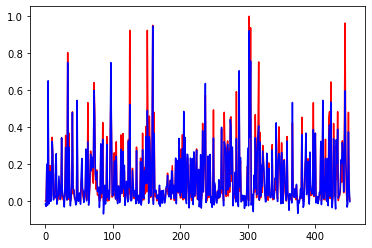

In [198]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_val, color='red')
plt.plot(pred_y, color='blue')
plt.show()

In [199]:
test_score= r2_score(y_val, pred_y)
print(test_score)

0.8877212397551084


In [200]:
feature= test_new[['평균기온(°C)', '최고기온(°C)', '최저기온(°C)', '월합강수량(00~24h만)(mm)', '합계 일사량(MJ/m2)', '면적']]
target= test_new[['생산량']]

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

In [201]:
feature_input= feature_sc.reshape(114, -1, 6)

In [202]:
pred_test= model.predict(feature_input)

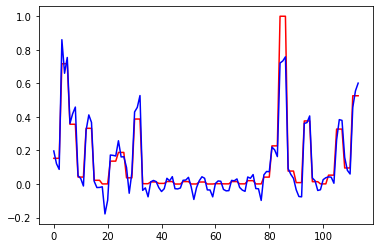

In [203]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(target_sc, color='red')
plt.plot(pred_test, color='blue')
plt.show()

In [204]:
test_score= r2_score(target_sc, pred_test)
print(test_score)

0.9141663855106846


In [206]:
diff= (pred_actual-target)/target * 100
diff

,생산량
행정구역,
강원도,28.332239
강원도,-20.849389
강원도,-42.906439
강원도,19.930149
강원도,-7.940818
...,...
충청북도,-14.559349
충청북도,-37.301116
충청북도,-13.162357


In [207]:
diff.median()

생산량   -5.930589
dtype: float64

c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\LG-PC\anacond

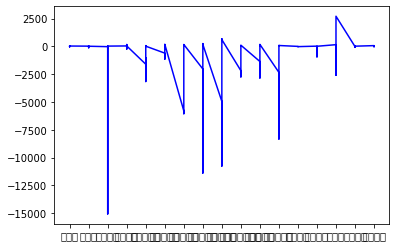

In [208]:
plt.figure()
plt.plot(diff, color='blue')
plt.show()

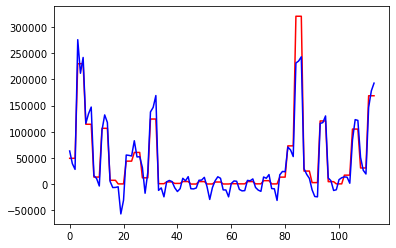

In [205]:
pred_actual= scaler2.inverse_transform(pred_test)
target_actual= scaler2.inverse_transform(target_sc)

plt.figure()
plt.plot(target_actual, color='red')
plt.plot(pred_actual, color='blue')
plt.show()